# GOOGLE DRIVE GRANT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ls "/content/drive/MyDrive/DATABASE"

 211.csv   fitur/  'PPG-BP dataset.xlsx'   raw_data/
 Clean/    model/   predictfitur/


# PPG 

## PPG MODELING 


Feature Extraction

In [188]:
import cv2
import numpy as np
from scipy import signal
import os
import shutil
"""
# This Function Works as follows:
1. Takes input as the path of the finger video 
2. Returns the resting heartrate in bpm as a number 


- It first gets frames from video at rate 20 frames per second
- Extract channels from the images 
- then it computes the average of the red channels and saves them in pixels_averages
- Then do a HPF to the average
- Truncate wonky data from  beginning of series
- Take FFT to the filtered data and the compute the heartrate in bpm.
"""
overall_results = []

def HeartRateFinger(Video_Path):
    os.makedirs("frames")  #make a directory called frames to save the images in
    vidcap = cv2.VideoCapture(Video_Path)  #the directory path to the video of interest
    images = []

    #take in images and get indidvual frames
    def getFrame(sec):
        vidcap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)  #VideoCaptureProperties to capture 
        hasFrames, image = vidcap.read()
        if hasFrames:
            cv2.imwrite("frames/image" + str(count) + ".jpg", image)  # save frame as JPG file
        images.append("frames/image" + str(count) + ".jpg")
        return hasFrames

    #set up frame rate
    sec = 0
    frameRate = 0.05  #capture frame each 0.05 seconds --> (1 second) / .05 = 20 seconds 20 fps
    count = 1
    success = getFrame(sec)  #success tracker
    while (success):
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success = getFrame(sec)

    #Get the channels from images and Find the average of RED channel for each frame
    pixels_averages = []
    for i in range(len(images) - 1):
        bgr_image = cv2.imread(images[i])
        blue_channel, green_channel, red_channel = cv2.split(bgr_image)  #splits into the 3 color channels (RGB)
        average = np.mean(red_channel)  #mean of all the red channels  is the sum all pixels in channel and divide by number of pixels
        pixels_averages.append(average)  #add this average to all the other frames array
    pixels_averages = np.divide(np.array(pixels_averages), 255)  #normalize our averages between 0-1

    #Clean and filter data (butterworth filter)
    sos = signal.butter(4, 1, 'hp', fs=20, output='sos')  # setting up signal.butter(kind of frequency,framerate, name of method)
    filtered = signal.sosfilt(sos, pixels_averages) #Applying filter

    # truncate wonky data from  beginning of series
    filtered = filtered[40:]

    #Perform FFT to find frequency of max amplitude
    Sample_rate = 20  #same as the frame rate is the sampling rate
    BW = Sample_rate / 2  #bandwidth (range of frequency) in signal processing
    fft = np.absolute(np.fft.fft(filtered))
    frames_len = len(filtered)
    frequancies = np.arange(0, BW, Sample_rate / frames_len)
    fft = fft[0:len(frequancies)]

    #Convert back to BPM from hz
    heartrate = np.round(frequancies[np.argmax(fft)] * 60)  #take the highest peak frequency and multiply by 60 and round it
    shutil.rmtree("frames")  #remove folder made to keep the directory clean
    overall_results.append(heartrate)
    return heartrate



In [189]:
#script expected outcome while Resting is 74-78 BPM
path = "95.MOV"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

ValueError: ignored

In [ ]:
#script expected outcome while Resting is 69-77 BPM
path = "resting1.mp4"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

In [ ]:
#script expected outcome while Resting is 69-77 BPM
path = "RESTING2.mp4"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

In [ ]:
#script expected outcome after activity was 83-88 BPM (50 jumping jacks)
path = "active1.mp4"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

In [ ]:
#script expected outcome after activity was 75-85 BPM (jogging for a bit)
path =  "active2.mp4"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

In [ ]:
#Overall results laid out with their error rate as well
print(overall_results)


## PPG CLASSIFICATION

1.   Cleaning Data
2.   Feature Extraction





## 1.Cleaning

In [144]:
"""AF"""

'AF'

In [145]:
#
import pandas as pd
import numpy as np
dfn1 = pd.read_csv('/content/drive/MyDrive/DATABASE/raw_data/AF2.csv')
dfn1

,Time,II,PLETH
0,11:20:01.367,8.46,-168.00
1,11:20:01.367,8.46,7.76
2,11:20:01.367,-14.32,-76.00
3,11:20:01.367,-8.96,-75.00
4,11:20:01.367,-8.01,-74.00
...,...,...,...
18150,11:26:03.625,-119.37,-152.00
18151,11:26:03.667,-64.40,-142.00
18152,11:26:03.667,18.58,-136.00
18153,11:26:03.716,18.06,-129.00


In [146]:
#check type data
print(type(dfn1['II'][0]))
print(type(dfn1['PLETH'][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [147]:
#memotong data 
dfn1 = dfn1.loc[200:]
dfn1

,Time,II,PLETH
200,11:20:05.085,4.44,-134.0
201,11:20:05.085,3.94,-125.0
202,11:20:05.134,2.54,-120.0
203,11:20:05.134,0.60,-112.0
204,11:20:05.184,-1.25,-105.0
...,...,...,...
18150,11:26:03.625,-119.37,-152.0
18151,11:26:03.667,-64.40,-142.0
18152,11:26:03.667,18.58,-136.0
18153,11:26:03.716,18.06,-129.0


In [148]:
#pembersihan objek dr str yg tdk terpakai
dfn1['II'].replace('', np.nan, inplace=True)
dfn1.dropna(subset=['II'], inplace=True)
dfn1['PLETH'].replace('', np.nan, inplace=True)
dfn1.dropna(subset=['PLETH'], inplace=True)

dfn1.head(1)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=m

,Time,II,PLETH
200,11:20:05.085,4.44,-134.0


In [149]:
dfn = pd.concat([dfn1]).reset_index(drop=True)
len(dfn)

17955

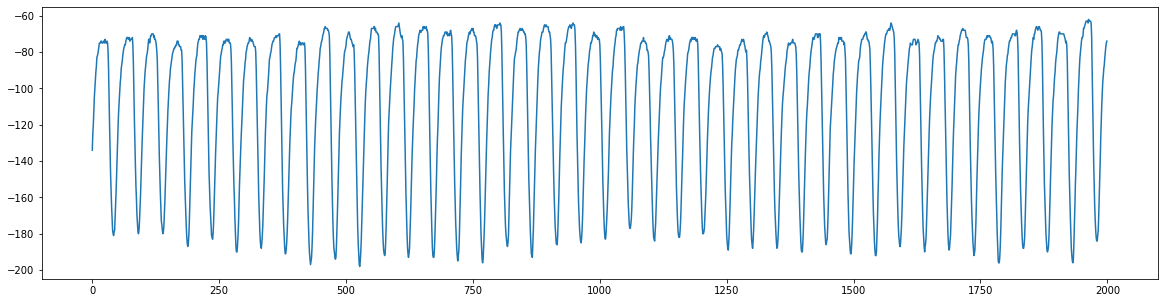

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(dfn['PLETH'][:2000])

In [152]:
dfn = dfn.loc[0:1899]
dfn.to_csv('/content/drive/MyDrive/DATABASE/Clean/af2clean.csv')

In [153]:
"""PVC"""

'PVC'

In [154]:
dfv1 = pd.read_csv('/content/drive/MyDrive/DATABASE/raw_data/PVC1.csv')
dfv1.head(1)

,Time,II,PLETH
0,00:01:58.112,0.36,0.516


In [155]:
print(type(dfv1['II'][0]))
print(type(dfv1['PLETH'][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [156]:
dfv1['II'].replace('', np.nan, inplace=True)
dfv1.dropna(subset=['II'], inplace=True)
dfv1['PLETH'].replace('', np.nan, inplace=True)
dfv1.dropna(subset=['PLETH'], inplace=True)

dfv1.head(1)

,Time,II,PLETH
0,00:01:58.112,0.36,0.516


In [157]:
dfv = pd.concat([dfv1]).reset_index(drop=True)
len(dfv)

951

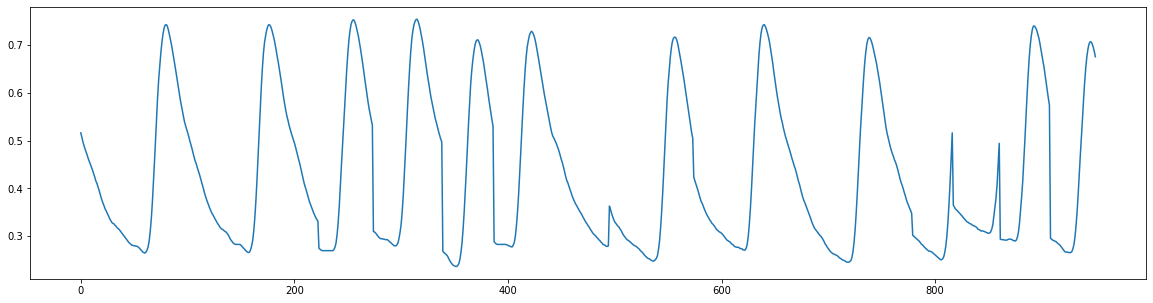

In [158]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(dfv['PLETH'][0:2000])

In [159]:
dfv = dfv.loc[0:1899]
dfv.to_csv('/content/drive/MyDrive/DATABASE/Clean/PVC2.csv')

In [160]:
"Normal"

'Normal'

In [162]:
import pandas as pd
import numpy as np
dfn1 = pd.read_csv('/content/drive/MyDrive/DATABASE/raw_data/N1.csv')

In [163]:
#check type data
print(type(dfn1['II'][0]))
print(type(dfn1['Pleth'][0]))

<class 'numpy.float64'>
<class 'numpy.int64'>


In [164]:
#memotong data 
dfn1 = dfn1.loc[100:]

In [166]:
#pembersihan objek dr str yg tdk terpakai
dfn1['II'].replace('', np.nan, inplace=True)
dfn1.dropna(subset=['II'], inplace=True)
dfn1['Pleth'].replace('', np.nan, inplace=True)
dfn1.dropna(subset=['Pleth'], inplace=True)

dfn1.head(1)

,Time,Pleth,II
100,20:56:13.146,-92,19.57


In [167]:
dfn = pd.concat([dfn1]).reset_index(drop=True)
len(dfn)

5364

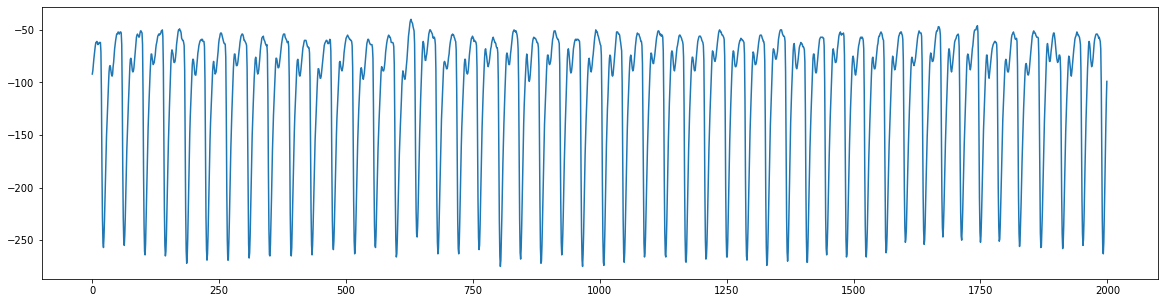

In [168]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(dfn['Pleth'][:2000])

In [190]:
dfn = dfn.loc[0:1899]
dfn.to_csv('/content/drive/MyDrive/DATABASE/Clean/N1.csv')

## 2.feature extraction

In [173]:
import pandas as pd
import numpy as np
dfn = pd.read_csv('/content/drive/MyDrive/DATABASE/Clean/af2clean.csv')
dfn

,Unnamed: 0,Time,II,PLETH
0,0,11:20:05.085,4.44,-134.0
1,1,11:20:05.085,3.94,-125.0
2,2,11:20:05.134,2.54,-120.0
3,3,11:20:05.134,0.60,-112.0
4,4,11:20:05.184,-1.25,-105.0
...,...,...,...,...
1895,1895,11:20:42.947,4.93,-99.0
1896,1896,11:20:42.947,2.98,-94.0
1897,1897,11:20:42.981,2.24,-91.0
1898,1898,11:20:42.981,1.86,-86.0


In [174]:
dfn.drop(['Unnamed: 0', 'Time'], axis=1, inplace=True)
dfn.head(1)

,II,PLETH
0,4.44,-134.0


In [175]:
# mencari peak sinyal pleth
import scipy.signal
peaksn,_ = scipy.signal.find_peaks(dfn['PLETH'], distance=30)
peaksn

array([  25,   79,  118,  168,  213,  265,  310,  368,  408,  459,  505,
        555,  604,  658,  706,  748,  803,  843,  894,  947,  988, 1046,
       1086, 1137, 1184, 1232, 1280, 1329, 1380, 1426, 1475, 1524, 1574,
       1619, 1666, 1715, 1763, 1821, 1860])

In [176]:
# hasil peak sinyal pleth
peaksnidxn = dfn['PLETH'][peaksn]
print(peaksnidxn)

25     -73.0
79     -72.0
118    -70.0
168    -74.0
213    -71.0
265    -73.0
310    -72.0
368    -70.0
408    -74.0
459    -66.0
505    -69.0
555    -66.0
604    -64.0
658    -66.0
706    -68.0
748    -67.0
803    -64.0
843    -67.0
894    -65.0
947    -64.0
988    -69.0
1046   -66.0
1086   -72.0
1137   -71.0
1184   -72.0
1232   -76.0
1280   -73.0
1329   -69.0
1380   -73.0
1426   -70.0
1475   -72.0
1524   -69.0
1574   -64.0
1619   -73.0
1666   -71.0
1715   -67.0
1763   -71.0
1821   -68.0
1860   -66.0
Name: PLETH, dtype: float64


In [177]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

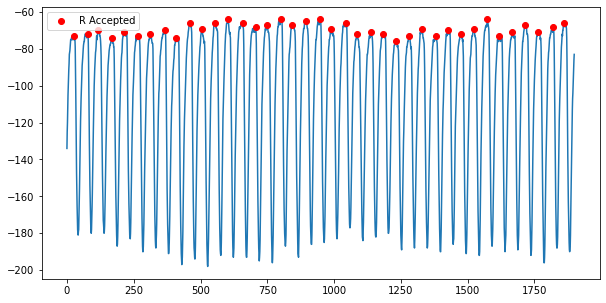

In [178]:
#plot peak R sinyal kedalam grafik
peakslabel = mlines.Line2D([], [], color='red', linestyle=' ', marker='o', label='R Accepted')
plt.figure(figsize=(10, 5))
plt.legend(handles=[peakslabel])
plt.plot(dfn['PLETH'])
plt.plot(peaksnidxn, 'o', color='red')

In [ ]:
#mengambil data pleth untuk dijadikan list dataaf[]
datan = []
for i in range(0,18):
  rown=[]
  for j in range(0,100):
    data = dfn['PLETH'][(i*100)+j]
    rown.append(data)
  datan.append(rown)

#print(datan)

[[-163.0, -155.0, -146.0, -139.0, -130.0, -122.0, -115.0, -107.0, -101.0, -96.0, -92.0, -88.0, -84.0, -81.0, -77.0, -76.0, -73.0, -71.0, -71.0, -69.0, -69.0, -68.0, -69.0, -70.0, -71.0, -72.0, -71.0, -69.0, -69.0, -68.0, -68.0, -68.0, -69.0, -71.0, -75.0, -86.0, -101.0, -116.0, -130.0, -143.0, -153.0, -161.0, -168.0, -171.0, -174.0, -174.0, -172.0, -169.0, -164.0, -158.0, -151.0, -142.0, -133.0, -125.0, -117.0, -109.0, -102.0, -96.0, -90.0, -87.0, -83.0, -80.0, -78.0, -76.0, -74.0, -73.0, -70.0, -70.0, -69.0, -69.0, -70.0, -67.0, -67.0, -66.0, -67.0, -66.0, -67.0, -67.0, -69.0, -70.0, -70.0, -72.0, -74.0, -82.0, -95.0, -111.0, -126.0, -139.0, -150.0, -159.0, -165.0, -169.0, -172.0, -174.0, -174.0, -173.0, -167.0, -160.0, -152.0, -144.0], [-134.0, -125.0, -120.0, -112.0, -105.0, -100.0, -96.0, -91.0, -88.0, -83.0, -82.0, -81.0, -79.0, -77.0, -75.0, -75.0, -75.0, -74.0, -74.0, -75.0, -75.0, -75.0, -74.0, -74.0, -75.0, -73.0, -74.0, -75.0, -75.0, -74.0, -75.0, -79.0, -89.0, -103.0, -120.0

In [ ]:
import pywt
import numpy as np
import statistics
# import csv, io
import Createdataset as c
import soft
import bwr
from sklearn.decomposition import PCA

In [ ]:
#Proses denoising
data_sample_n = []
baseline_n = []
ppg_out_n = []
for i in range(0,18):
    sinyal = soft.waveletSmooth(datan[i])
    (baseline, ppg_out) = bwr.bwr(sinyal)
    len_sample = len(datan[i])

    sampled_window = len_sample
    sample = []
    for j in range(sampled_window):
        sample.append(ppg_out[j - 1])
    data_sample_n.append(sample)
    baseline_n.append(baseline)
    ppg_out_n.append(ppg_out)

In [ ]:
print(data_sample_n)

[[-77.6879293062688, -68.35132710025908, -62.65599302725917, -52.91064906313112, -45.22522144369978, -38.86871538014341, -31.23491133827237, -24.002098058192132, -16.9942364669307, -10.394710221478746, -5.152154705752622, -1.6448403662873545, 2.488187688147889, 7.031014543305346, 10.582665557286717, 13.330322457388391, 15.878785479054471, 18.029671654731985, 19.04175608963962, 19.508745680673684, 19.858810740644273, 20.135353804651018, 20.285816757060616, 20.253218208258517, 20.086801045030157, 19.78222061539917, 19.029667923116875, 18.359275026851506, 18.010615922946428, 18.105744970374744, 17.96841562591102, 18.402625878657915, 16.739794788091302, 12.845786389857537, 10.435523793701009, 6.897209560885159, -1.8370441085179436, -16.187529880382982, -30.073043920732417, -44.47030093499143, -57.13856667102239, -66.68053221573882, -74.91673782864964, -80.10022254246766, -84.54004782887846, -88.042136119054, -88.65434057254409, -85.92055960646492, -83.08337516211913, -79.7932265220408, -72

In [ ]:
# event sinyal af per sinyal
r_peaks_n = []
list_upper_n = []
for h in range(0,len(data_sample_n)):
  m = np.max(data_sample_n[h])
  R = 0.2 * m
  list_upper = []
  r_peaks = []
  for i in range(len(data_sample_n[h])-1):
    if (data_sample_n[h][i] > R):
      list_upper.append(data_sample_n[h][i])
      if (data_sample_n[h][i + 1] < R):
          r_peak = np.max(list_upper)
          r_in = data_sample_n[h].index(r_peak)
          r_peaks.append([r_in, r_peak])
          list_upper = []

  r_peaks_n.append(r_peaks)

In [ ]:
print(r_peaks_n)

[[[22, 20.285816757060616], [65, 38.102064085080656]], [[17, 16.064369049427356], [65, 43.22311810169029]], [[18, 16.840078001964585], [65, 47.74728864057268]], [[17, 16.22067585114982], [65, 52.32204316485303]], [[17, 15.050041702300533], [65, 57.3328449225981]], [[17, 17.174738790933546], [65, 60.124351728588735]], [[4, 19.878911509376096], [65, 52.21771546565549]], [[4, 23.468268077765586], [60, 36.14974855383204]], [[7, 23.930133920059646], [53, 25.92840450260212]], [[3, 49.70024418197636], [40, 19.707472962757322]], [[2, 44.08860043078565], [40, 21.52771021160939]], [[1, 42.42444565705891], [47, 23.348437881135823], [78, 28.913580200040087]], [[41, 23.75553208139675], [79, 14.985712753958722]], [[26, 24.249307594509105], [73, 21.481577044214035]], [[25, 28.13099173586201], [72, 28.348507924417248]], [[25, 24.66320948616685], [65, 37.67952647117038]], [[24, 20.329634296704242], [65, 47.51219607374324]], [[27, 15.536888886051798], [65, 48.761084684187594]]]


In [ ]:
#interval per sinyal tiap event af
r_intervals_n = []
for h in range(0,len(r_peaks_n)):
  r_intervals = []
  for i in range(len(r_peaks_n[h]) - 1):
    r1 = r_peaks_n[h][i][0]
    r2 = r_peaks_n[h][i + 1][0]
    rr = r2 - r1
    r_intervals.append(rr)

  r_intervals_n.append(r_intervals)

In [ ]:
print(r_intervals_n)

[[24, 69], [21], [18], [15], [13], [10], [], [], [], [], [], [], [], [], [22, 73], [21], [18], [16]]


In [ ]:
ca_n = []
for i in range(0,len(ppg_out_n)):
  nlevelmax = pywt.dwt_max_level(len(ppg_out_n[i]), 'sym3')
  coeff = pywt.wavedec(ppg_out_n[i], 'sym3', level=6)
  ca_n.append(coeff[0])

In [ ]:
len(ca_n)

18

In [ ]:
hasil_n = []
for i in range(0,len(ca_n)):
  (min, max, mean, med, std) = c.Createdataset(ca_n[i])
  hasil = [min, max, mean, med, std, ""]
  hasil_n.append(hasil)

In [ ]:
result_n = pd.DataFrame(hasil_n, columns = ['min','max','mean','med','std','label'])
result_n

,min,max,mean,med,std,label
0,-0.854141,-0.205031,-0.431257,-0.291098,0.263837,N
1,-0.935841,-0.201251,-0.457331,-0.299173,0.298529,N
2,-0.985227,-0.247203,-0.504422,-0.345064,0.299977,N
3,-1.076965,-0.276733,-0.555677,-0.382976,0.325253,N
4,-1.178858,-0.266919,-0.584753,-0.387740,0.370675,N
5,-1.204988,-0.344583,-0.644506,-0.458868,0.349702,N
6,-1.234019,-0.359042,-0.664064,-0.474846,0.355662,N
7,-1.245315,-0.385040,-0.684897,-0.498874,0.349699,N
8,-1.263802,-0.385874,-0.691914,-0.502189,0.356851,N
9,-1.242340,-0.399670,-0.693406,-0.511452,0.342507,N


In [ ]:
dfpvc = pd.read_csv('clean/AF2_clean/AF2_2clean.csv')

In [ ]:
dfpvc.drop(['Unnamed: 0', 'Time'], axis=1, inplace=True)
dfpvc

,II,PLETH
0,0.435,0.257
1,0.435,0.256
2,0.430,0.255
3,0.435,0.254
4,0.435,0.253
5,0.430,0.254
6,0.430,0.257
7,0.440,0.266
8,0.430,0.283
9,0.435,0.306


In [ ]:
len(dfpvc)

1800

In [ ]:
import scipy.signal
peakspvc,_ = scipy.signal.find_peaks(dfpvc['PLETH'], distance=100)
peakspvc

array([  23,  217,  411,  606,  799, 1090, 1220, 1320, 1517, 1714],
      dtype=int64)

In [ ]:
peaksnidxpvc = dfpvc['PLETH'][peakspvc]
print(peaksnidxpvc)

23      0.714
217     0.749
411     0.720
606     0.755
799     0.717
1090    0.742
1220    0.761
1320    0.742
1517    0.733
1714    0.756
Name: PLETH, dtype: float64


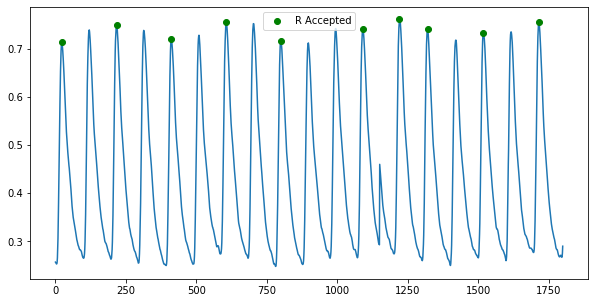

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
peakslabel = mlines.Line2D([], [], color='green', linestyle=' ', marker='o', label='R Accepted')
plt.figure(figsize=(10, 5))
plt.legend(handles=[peakslabel])
plt.plot(dfpvc['PLETH'])
plt.plot(peaksnidxpvc, 'o', color='green')

In [ ]:
datapvc = []
for i in range(0,9):
  rowpvc=[]
  for j in range(0,200):
    data = dfpvc['PLETH'][(i*200)+j]
    rowpvc.append(data)
  datapvc.append(rowpvc)

# print(datapvc)

In [ ]:
import pywt
import numpy as np
import statistics
# import csv, io
import Createdataset as c
import soft
import bwr
from sklearn.decomposition import PCA

In [ ]:
data_sample_pvc = []
baseline_pvc = []
ppg_out_pvc = []
for i in range(0,9):
    sinyal = soft.waveletSmooth(datapvc[i])
    (baseline, ppg_out) = bwr.bwr(sinyal)
    len_sample = len(datapvc[i])

    sampled_window = len_sample
    sample = []
    for j in range(sampled_window):
        sample.append(ppg_out[j - 1])
    data_sample_pvc.append(sample)
    baseline_pvc.append(baseline)
    ppg_out_pvc.append(ppg_out)

# print(data_sample_pvc)

In [ ]:
r_peaks_pvc = []
list_upper_pvc = []
for h in range(0,len(data_sample_pvc)):
  m = np.max(data_sample_pvc[h])
  R = 0.2 * m
  list_upper = []
  r_peaks = []
  for i in range(len(data_sample_pvc[h])-1):
    if (data_sample_pvc[h][i] > R):
      list_upper.append(data_sample_pvc[h][i])
      if (data_sample_pvc[h][i + 1] < R):
          r_peak = np.max(list_upper)
          r_in = data_sample_pvc[h].index(r_peak)
          r_peaks.append([r_in, r_peak])
          list_upper = []

  r_peaks_pvc.append(r_peaks)

print(r_peaks_pvc)

[[[0, 0.185158201186156], [24, 0.29876164255290816], [121, 0.27035714246397585]], [[0, 0.27508716441193315], [18, 0.28046779502191066], [113, 0.3352627826673301]], [[0, 0.37911625003019656], [13, 0.29721158335675246], [110, 0.35725379132968255]], [[0, 0.45724226130835255], [103, 0.37751800745625386]], [[0, 0.4304848993714781], [97, 0.3594736360261035]], [[1, 0.2357757986427796], [92, 0.4103165825126923], [151, 0.19224523721421366]], [[0, 0.18205476055537034], [22, 0.3074873933960066], [121, 0.2780249094849083]], [[0, 0.1805741822702119], [21, 0.2868899050935498], [117, 0.28951108615317106]], [[0, 0.20823816196695344], [17, 0.2801607910106243], [114, 0.3376211474539773]]]


In [ ]:
r_intervals_pvc = []
for h in range(0,len(r_peaks_pvc)):
  r_intervals = []
  for i in range(len(r_peaks_pvc[h]) - 1):
    r1 = r_peaks_pvc[h][i][0]
    r2 = r_peaks_pvc[h][i + 1][0]
    rr = r2 - r1
    r_intervals.append(rr)

  r_intervals_pvc.append(r_intervals)

print(r_intervals_pvc)

[[24, 97], [18, 95], [13, 97], [103], [97], [91, 59], [22, 99], [21, 96], [17, 97]]


In [ ]:
ca_pvc = []
for i in range(0,len(ppg_out_pvc)):
  nlevelmax = pywt.dwt_max_level(len(ppg_out_pvc[i]), 'sym3')
  coeff = pywt.wavedec(ppg_out_pvc[i], 'sym3', level=6)
  ca_pvc.append(coeff[0])

print(ca_pvc)

[array([-1.31415711, -1.39280186, -1.5918615 , -0.39213467,  0.20855765,
       -0.1552697 ,  0.71097797,  1.74299131]), array([-1.46784797, -1.50694764, -1.87838899, -0.33460917,  0.05105638,
       -0.04913987,  0.82566548,  2.11947201]), array([ 0.24820034,  0.24371809, -0.03602616,  0.94172983, -0.09286364,
        0.46379744,  1.08523208,  2.49740416]), array([ 1.99588709,  2.00310957,  1.95220163,  1.92709303, -0.02395996,
        0.22263759,  1.66443761,  3.91046952]), array([ 2.44061239,  2.44683741,  2.52434498,  1.97935693,  0.17550179,
       -0.12994517,  1.981249  ,  4.22380286]), array([1.74517315, 1.74942486, 1.84815222, 1.21099772, 0.34051802,
       1.20207656, 0.7565158 , 0.68688975]), array([-1.56593034, -1.64000728, -1.91566913, -0.48071387,  0.20217571,
       -0.1426589 ,  0.68885893,  1.72325781]), array([-1.47012896, -1.52911221, -1.83188507, -0.41941872,  0.13347437,
       -0.10431169,  0.70248841,  1.71975989]), array([-1.31124341, -1.34538025, -1.71068239, -

C:\Users\Asus\Anaconda3\lib\site-packages\pywt\_multilevel.py:45: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [ ]:
hasil_pvc = []
for i in range(0,len(ca_pvc)):
  (min, max, mean, med, std) = c.Createdataset(ca_pvc[i])
  hasil = [min, max, mean, med, std, "PVC"]
  hasil_pvc.append(hasil)

In [ ]:
result_pvc = pd.DataFrame(hasil_pvc, columns = ['min','max','mean','med','std','label'])
result_pvc

,min,max,mean,med,std,label
0,-2.788173,4.410865,1.415018,2.658240,3.311823,PVC
1,-3.726648,2.613808,-2.109423,-3.272630,2.405648,PVC
2,-1.704572,5.664849,0.897159,0.171735,2.662093,PVC
3,-2.349414,4.508151,1.527345,2.676652,3.198742,PVC
4,-2.166665,0.134389,-1.369719,-1.725359,0.895773,PVC
5,-4.099490,1.465312,-2.550504,-3.371656,2.002869,PVC
6,-3.627363,3.569743,-1.310791,-3.260244,2.953026,PVC
7,-2.837763,6.474359,2.002781,2.374562,2.748522,PVC
8,-2.046246,1.763602,0.244753,0.627500,1.334977,PVC


In [ ]:
dfready = pd.concat([result_n, result_pvc]).reset_index(drop=True)
dfready.to_csv('/content/drive/MyDrive/DATABASE/model/datareadyPVC1.csv')

# DWT 



## Wavelet Extraction

In [ ]:
import numpy as np
import statistics
import pywt
import csv
from scipy.stats import kurtosis

# Reading file and saving it in a variable, suppose x;
x = np.array([])
y = np.array([])
filename = '/content/drive/MyDrive/DATABASE/211.csv' #file imput 
with open(filename) as csvfile:
    f_read = csv.reader(csvfile, delimiter = ',')
    for row in f_read:
        #x = np.append(x, [float(j) for j in row])
        x.append(float(row[0]))
        #y.append(float(row[2]))
        if row[2][:1] == '-' :
            if row[2][1:len(row[2])] == '' :
                #print(float(row[0]),'error')
                y.append(0)
            else :
                curr = float(row[2][1:len(row[2])])
                curr = float(-curr)
                #print(curr)
                y.append(curr)
        else :
            y.append(float(row[2]))
            #print('test')

[a, d1, d2, d3, d4] = pywt.wavedec(y, 'haar', level=4)

def comp_moment(feature):
    step = int(len(feature)/2)
    avg_temp = np.zeros([2])
    stn_dev_temp = np.zeros([2])
    kurto_temp = np.zeros([2])
    for i in range(int(len(feature)/step)):
        avg_temp[i] = np.mean(feature[step*i:step*(i+1)])
        stn_dev_temp[i] = statistics.stdev(feature[step*i:step*(i+1)])
        kurto_temp[i] = kurtosis(feature[step*i:step*(i+1)])
        return (avg_temp, stn_dev_temp, kurto_temp)


    #Approximation coeficient
    avg_temp, stn_dev_temp, kurto_temp = comp_moment(a)
    avg = avg_temp
    stn_dev = stn_dev_temp
    kurto = kurto_temp

    # d1 coffiecient
    avg_temp, stn_dev_temp, kurto_temp = comp_moment(d1)
    avg = np.append(avg, avg_temp)
    stn_dev = np.append(stn_dev, stn_dev_temp)
    kurto = np.append(kurto, kurto_temp)

    # d2 coffiecient
    avg_temp, stn_dev_temp, kurto_temp = comp_moment(d2)
    avg = np.append(avg, avg_temp)
    stn_dev = np.append(stn_dev, stn_dev_temp)
    kurto = np.append(kurto, kurto_temp)

    # d3 coffiecient
    avg_temp, stn_dev_temp, kurto_temp = comp_moment(d3)
    avg = np.append(avg, avg_temp)
    stn_dev = np.append(stn_dev, stn_dev_temp)
    kurto = np.append(kurto, kurto_temp)

    # d4 coffiecient
    avg_temp, stn_dev_temp, kurto_temp = comp_moment(d4)
    avg = np.append(avg, avg_temp)
    stn_dev = np.append(stn_dev, stn_dev_temp)
    kurto = np.append(kurto, kurto_temp)

    feature_dwt = np.append(np.append(avg, stn_dev), kurto)

AttributeError: ignored

In [ ]:
  import matplotlib.pyplot as plt
import csv

x = []
y = []

with open('211.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        x.append(int(row[0]))
        y.append(int(row[1]))

#plt.plot(x,y, label='Loaded from file!')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.title('Interesting Graph\nCheck it out')
#plt.legend()
#plt.show()

FileNotFoundError: ignored

In [ ]:
#from scipy.signal import argrelmax, argrelmin
import numpy as np 
from libraries import *
import os
from time import time

"""
Import classifier
"""
skenario = "fitur_skenario_3/"
nama_fitur = "gabungan"

fitur_path = skenario+nama_fitur
lokasi_model = "model_skenario/"+skenario

import pickle
clf = pickle.load(open(lokasi_model+"/KNN_7_"+nama_fitur+".sav","rb"))
"""
Generate Features and Classes
"""
hasil = []
for filename in os.listdir(fitur_path):
    if (".csv" in filename):
        start = time()
        nomor = filename.replace(".csv","")
        print(nomor)
        try:
            feature_list, class_list = read_feature_from_csv(fitur_path+"/%s.csv" % nomor)
            pred = clf.predict(feature_list)
            hasil.append(generate_confusion_matrix(nomor,class_list,pred,smoothing=False))
        except Exception as e:
            print("failed",e)
            print(time() - start, "second")

"""
Export Result to CSV
"""
columns_list = ["Sample_Data", "Normal","PAC","PVC","pred_Normal", "pred_PAC","pred_PVC","True_Positive_PAC","False_Positive_PAC","True_Negative_PAC","False_Negative_PAC","Accuracy_PAC","Spesifisity_PAC","sn_PAC","True_Positive_PVC", "False_Positive_PVC", "True_Negative_PVC", "False_Negative_PVC","Accuracy_PVC","Spesifisity_PVC","sn_PVC"]
pd.DataFrame(hasil,columns=columns_list).to_csv("hasil_skenario/"+fitur_path+"/confusion_matrix_fitur_"+nama_fitur+".csv",index=False)

data = pd.DataFrame(hasil)